## Breast Cancer Data Challenge

Task: develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell.

In [324]:
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted

warnings.filterwarnings('ignore')

In [117]:
DATA_PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
data = pd.read_csv(DATA_PATH,
                   names=[
                       'id', 'clump_thickness', 'size_uniformity',
                       'shape_uniformity', 'adhesion', 'cell_size',
                       'bare_nuclei', 'bland_chromatin', 'normal_nucleoli',
                       'mitoses', 'target'
                   ])
features = np.array([
    'clump_thickness', 'size_uniformity', 'shape_uniformity', 'adhesion',
    'cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses'
])

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                699 non-null    int64 
 1   clump_thickness   699 non-null    int64 
 2   size_uniformity   699 non-null    int64 
 3   shape_uniformity  699 non-null    int64 
 4   adhesion          699 non-null    int64 
 5   cell_size         699 non-null    int64 
 6   bare_nuclei       699 non-null    object
 7   bland_chromatin   699 non-null    int64 
 8   normal_nucleoli   699 non-null    int64 
 9   mitoses           699 non-null    int64 
 10  target            699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


"bare_nuclei" is object type. Taking a closer look shows some '?' values. I will treat these are missing values.

In [119]:
data['bare_nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

In [120]:
proc_data = data.replace('?', np.nan).copy()
proc_data['bare_nuclei'] = proc_data['bare_nuclei'].astype(float)

## Data Cleaning

2    458
4    241
Name: target, dtype: int64


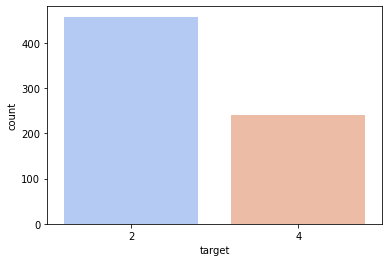

In [123]:
sns.countplot(proc_data.target, palette='coolwarm');
print(proc_data.target.value_counts())

There is good representation from both classes.

**Duplicate Data**

In [126]:
# Find rows that have been entirely duplicated
# We will keep one of these rows
proc_data = proc_data.drop_duplicates()
print(proc_data.shape)

(691, 11)


8 rows were dropped as they were complete duplicates. Let's look at rows where only the id is duplicated.

In [130]:
# Find ids that have been duplicated
# We will remove all such rows as this data would be unreliable
proc_data = proc_data.drop_duplicates(subset=['id'], keep=False)
print(proc_data.shape)

(606, 11)


Unfortunately 85 rows were dropped but it is important that false data records are not included in analysis of medical data.

2    378
4    228
Name: target, dtype: int64


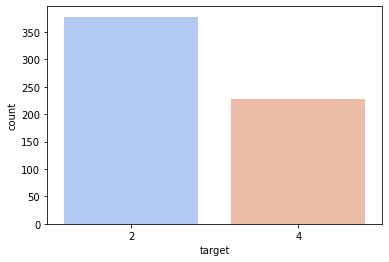

In [135]:
sns.countplot(proc_data.target, palette='coolwarm');
print(proc_data.target.value_counts())

The classes are more balanced after removing duplicates.

**Missing Data**

In [131]:
proc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606 entries, 0 to 696
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                606 non-null    int64  
 1   clump_thickness   606 non-null    int64  
 2   size_uniformity   606 non-null    int64  
 3   shape_uniformity  606 non-null    int64  
 4   adhesion          606 non-null    int64  
 5   cell_size         606 non-null    int64  
 6   bare_nuclei       591 non-null    float64
 7   bland_chromatin   606 non-null    int64  
 8   normal_nucleoli   606 non-null    int64  
 9   mitoses           606 non-null    int64  
 10  target            606 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 56.8 KB


There are 15 missing values in "bare_nuclei" (2.4%). Let's look at the class distribution.

In [136]:
proc_data.loc[pd.isna(proc_data.bare_nuclei)].target.value_counts()

2    13
4     2
Name: target, dtype: int64

The missing values are disproportionately from the Benign class but they represent less than 3% of the rows so I am choosing to remove them.

In [257]:
proc_data = proc_data.dropna()
print(proc_data.shape)

(591, 11)


## Exploration

In [258]:
def plot_corr_map(data, center=None):
    f, ax = plt.subplots(figsize=(10, 6))
    corr = data.corr()
    hm = sns.heatmap(round(corr, 2),
                     annot=True,
                     ax=ax,
                     cmap="coolwarm",
                     fmt='.2f',
                     linewidths=.05,
                     center=center)
    f.subplots_adjust(top=0.93)
    t = f.suptitle('User Data Correlation Heatmap', fontsize=16)
    return f

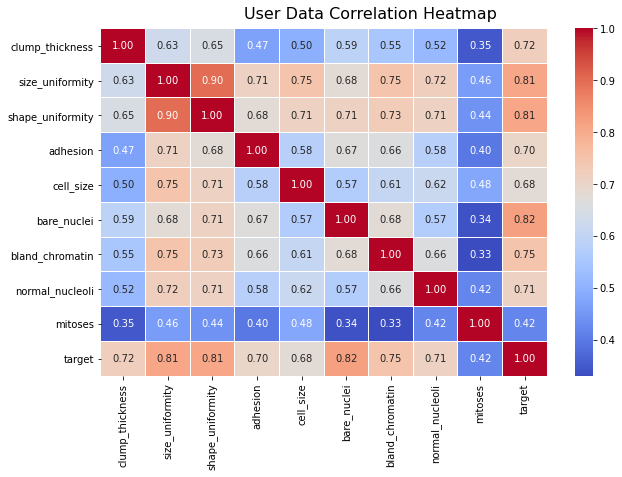

In [259]:
fig1 = plot_corr_map(proc_data.drop(['id'], axis=1))

Features are significantly correlated with each other. size_uniformity and shape_uniformity are especially highly correlated. We can explore only keeping one of these are evaluating model performance when one is swapped with the other.

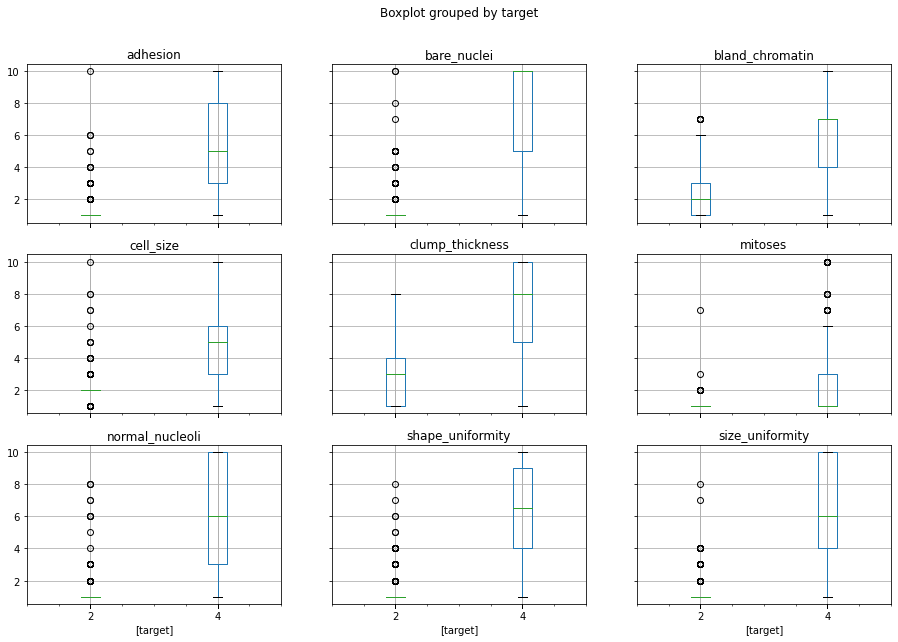

In [260]:
proc_data.drop(['id'],axis=1).boxplot(by='target', figsize=(15,10));

There is a clear difference in spread of features between the classes.

## Modelling

**Custom switchers for feature selection and model selection to be used in grid search**

In [359]:
class FeatureSelector(TransformerMixin, BaseEstimator):
    '''Select features using any sklearn method'''
    def __init__(self, transformer = None):
        self.transformer = transformer

    def fit(self, X, y=None, **kwargs):
        if self.transformer:
            self.transformer.fit(X, y)
        return self

    def transform(self, X):
        if self.transformer:
            X_r = self.transformer.transform(X)
            return X_r
        else:
            return X

In [360]:
class ClfEstimator(BaseEstimator):
    '''Choose model for classification'''
    def __init__(self, estimator = LogisticRegression()):
        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        check_is_fitted(self.estimator)
        return self.estimator.predict(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

**Metrics**

Recall is the key metric of choice here as we want to minimze false negatives.

In [361]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot a confusion matrix and return confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    f, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap="Blues", square=True, ax=ax, fmt='.0f')
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    return cm

In [362]:
def cv_score_statistics(estimator, X, y, scoring='recall', cv=5, n_jobs=-1):
    scores = cross_val_score(estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs)
    print('All scores:\n', np.sort(scores), '\n')
    print('Mean:', np.round(np.mean(scores), 3))
    print('Median:', np.round(np.median(scores),3))
    print('SD:', np.round(np.std(scores), 3))

**Train and Test Set**

In [394]:
X = proc_data.drop(['id', 'size_uniformity', 'target'], axis=1).copy()
# drop size_uniformity because it is highly correlated with shape_uniformity
y = proc_data['target'].copy()
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y)

**Pipeline**

In [375]:
pipeline = Pipeline(steps=[
    ('fs', FeatureSelector()),
    ('classifier', ClfEstimator())
])

**Baseline Model**

In [376]:
pipeline.fit(X, y)
y_pred = pipeline.predict(X_train)

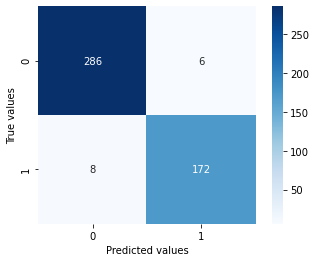

In [377]:
#Confusion Matrix
plot_confusion_matrix(y_train, y_pred);

In [378]:
print(classification_report(y_train, y_pred, target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       0.97      0.98      0.98       292
   Malignant       0.97      0.96      0.96       180

    accuracy                           0.97       472
   macro avg       0.97      0.97      0.97       472
weighted avg       0.97      0.97      0.97       472



In [382]:
cv_score_statistics(pipeline, X_train, y_train)

All scores:
 [0.87878788 0.95652174 0.97058824 1.         1.        ] 

Mean: 0.961
Median: 0.971
SD: 0.045


Mean recall is 96% but there is some unstability in the scores between the folds. Let's see if we can do better.

## Feature Selection and Model Selection / Tuning

In [522]:
params = [
    {
        'fs__transformer': [SelectFromModel(LogisticRegression(), threshold=-np.inf)],
        'fs__transformer__max_features': np.arange(3,9),
        'classifier__estimator': [xgb.XGBClassifier(), LogisticRegression(), RandomForestClassifier(), SVC()],
    },
    {
        'fs__transformer': [RFE(LogisticRegression())],
        'fs__transformer__n_features_to_select': np.arange(3,9),
        'classifier__estimator': [xgb.XGBClassifier(), LogisticRegression(), RandomForestClassifier(), SVC()],
    }]
grid = GridSearchCV(pipeline,
                    params,
                    cv=5,
                    verbose=0,
                    n_jobs=-1,
                    scoring='recall'
                   )
grid.fit(X_train, y_train)
print('Best parameters:', grid.best_params_)
print('Best score:', grid.best_score_)

Best parameters: {'classifier__estimator': RandomForestClassifier(), 'fs__transformer': RFE(estimator=LogisticRegression(), n_features_to_select=8), 'fs__transformer__n_features_to_select': 8}
Best score: 0.9852437417654809


In [470]:
cv_score_statistics(grid.best_estimator_, X_train, y_train)

All scores:
 [0.93939394 0.97826087 1.         1.         1.        ] 

Mean: 0.984
Median: 1.0
SD: 0.024


In a preliminary comparison between classifiers with default parameters, the random forest classifier does a better job classifying. The recall is better and more stable across the folds. Let's tune the model and feature selection further using Random Forest.

In [505]:
# Now we will use RandomForest importances to recursively select features and tune the model
params = [
    {
        'fs__transformer': [RFE(RandomForestClassifier())],
        'fs__transformer__n_features_to_select': np.arange(3,9),
        'classifier__estimator': [RandomForestClassifier()],
        'classifier__estimator__n_estimators': [200],
        'classifier__estimator__max_depth': [2,3]
    }]
grid = GridSearchCV(pipeline,
                    params,
                    cv=5,
                    verbose=0,
                    n_jobs=-1,
                    scoring='recall'
                   )
grid.fit(X_train, y_train)
print('Best parameters:', grid.best_params_)
print('Best score:', grid.best_score_)

Best parameters: {'classifier__estimator': RandomForestClassifier(max_depth=2, n_estimators=200), 'classifier__estimator__max_depth': 2, 'classifier__estimator__n_estimators': 200, 'fs__transformer': RFE(estimator=RandomForestClassifier(), n_features_to_select=7), 'fs__transformer__n_features_to_select': 7}
Best score: 0.9895915678524375


In [506]:
y_pred = grid.predict(X_train)

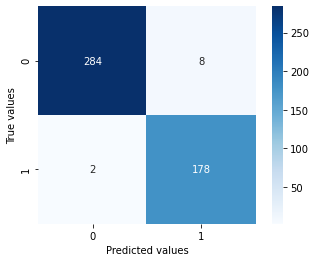

In [507]:
#Confusion Matrix
plot_confusion_matrix(y_train, y_pred);

In [508]:
print(classification_report(y_train, y_pred, target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       0.99      0.97      0.98       292
   Malignant       0.96      0.99      0.97       180

    accuracy                           0.98       472
   macro avg       0.97      0.98      0.98       472
weighted avg       0.98      0.98      0.98       472



The recall for Malignant tumors improved from 96% to 99% without any loss in precision.

In [509]:
# Feature importance
selected_features = X_train.columns[grid.best_estimator_.named_steps['fs'].transformer.support_]
importances = grid.best_estimator_.named_steps['classifier'].estimator.feature_importances_
imp = pd.DataFrame({'feature': selected_features, 'importance': importances})
imp = imp.sort_values(by='importance', ascending=False)

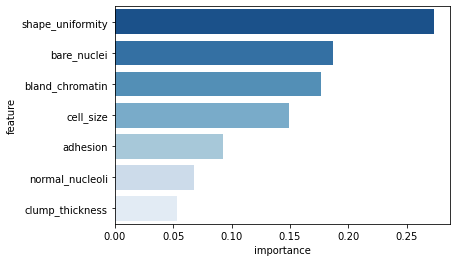

In [510]:
sns.barplot(x='importance', y='feature', data=imp, orient='h', palette='Blues_r');

We can see only 7 features are the optimum number of features for achieving a very high recall (99%). The task objective however mentions that there is a time and monetary cost associated with collecting every feature. So let's see what the recall score looks like for other feature selections.

In [511]:
grid.cv_results_['mean_test_score']

array([0.93817533, 0.97764861, 0.97380583, 0.98370921, 0.98959157,
       0.98959157, 0.96057581, 0.96564144, 0.96735422, 0.97936139,
       0.98959157, 0.98524374])

3 or 4 features gives 96% recall, 5 or 6 features gives ~97% recall and 7 or 8 features give 98% recall on the train set. Depending on the cost benefit analysis an appropriate set of features can be chosen from the above.

## Test Set Performance

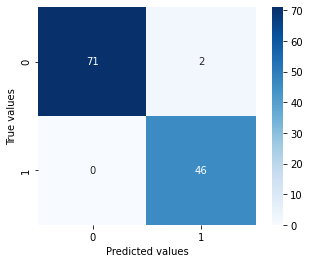

In [519]:
y_pred = grid.predict(X_test)
plot_confusion_matrix(y_test, y_pred);

In [520]:
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       1.00      0.97      0.99        73
   Malignant       0.96      1.00      0.98        46

    accuracy                           0.98       119
   macro avg       0.98      0.99      0.98       119
weighted avg       0.98      0.98      0.98       119



We see excellent performance on the test set with a 100% recall on the malignant class and 98% accuracy. 

## Insights

* The model could identify malignant tumors with 98% accuracy and a recall of 99% on the malignant class in the train set.
* The model could identify malignant tumors with 98% accuracy and a recall of 100% on the malignant class in the test set.
* While 7 features were found to give best performance (recall of 99%), it is possible to trade lower number of features for a poorer recall. For instance using just the 5 or 6 most important features gives a slightly lower recall of 97% on the train set. This will depend on the cost versus benefit of collecting the extra features.
* The features in order of importance are:

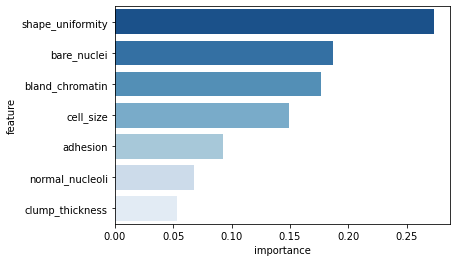

In [521]:
sns.barplot(x='importance', y='feature', data=imp, orient='h', palette='Blues_r');